# Load and clean the raw data

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import datetime
import string
import network_creation_functions as ncf
from importlib import reload

In [2]:
src = '../data/raw/Grunddaten-Simulation'

In [3]:
! ls ../data/raw/Grunddaten-Simulation

 Bedienstete_mit_DV_an_Org.csv	 Prüfungstermine_mit_Räumen.csv
 Lehrende.csv			 Räume.csv
 LV.csv				 Studiendaten.csv
 Prüfungen-2.csv		 Studierende_pro_LV.csv
 Prüfungen.csv			 Studierende_pro_LV_mit_Idf.csv
 Prüfungstermine.csv		'Termine_mit_LV Bezug.csv'


In [4]:
semester_start = ncf.semester_start # date of the semester start
semester_end = ncf.semester_end # date of the semester end
study_map = ncf.study_map # mapping of studies to degree levels

## Studies

In [5]:
# List of studies for every student. A student can have more than one study,
# which will show up as separate entries (row) for the same student_id. Each
# study also has a term number, i.e. the number of semesters the student has
# been enrolled in the given study.
studies = pd.read_csv(join(src, 'Studiendaten.csv'), encoding='latin_1')
studies = studies.rename(columns={
    'ST_PERSON_NR':'student_id', # unique student identifier
    'STUDIENIDENTIFIKATOR':'study_id', # unique study identifier
    'STUDIENBEZEICHNUNG':'study_name', # (german) name of the study
    'SEMESTERANZAHL':'term_number' # number of terms a student has been enrolled
})

# the text before the semicolon in the study_name field describes (approximately) 
# the degree and is mapped to a unified pre / post graduate degree scheme that was
# informed by Timotheus Hell
studies['study_level'] = studies['study_name'].apply(lambda x: x.split(';')[0])
studies['study_level'] = studies['study_level'].replace(study_map)

studies.head(2)

,student_id,study_id,study_name,term_number,study_level
0,163460,UB 198 407 417 01,Bachelorstudium Lehramt Sek (AB); UF Englisch;...,7,bachelor
1,208510,UB 198 410 411 01,Bachelorstudium Lehramt Sek (AB); UF Geographi...,1,bachelor


## Students

### Load and describe data

In [6]:
# List of enrolled lectures of the WiSe 2019/20 for every student. A lecture
# can have several groups (for example for tutorial parts). The group
# identifier is also listed for every student. It is not completely unique
# as there are a number of overlapping groups (for example same time, 
# different rooms). These are disambiguated at a later point in the data
# cleaning process.
# The data also includes the identifier of the study through which the 
# student enrolled in a given lecture. 
students = pd.read_csv(join(src, 'Studierende_pro_LV_mit_Idf.csv'))
students = students.rename(columns={
    'ST_PERSON_NR':'student_id', # unique student identifier
    'STP_SP_NR':'lecture_id', # unique lecture identifier
    'LV_GRP_NR':'group_id', # (almost) unique group identifier 
    'STUDIENIDENTIFIKATOR':'study_id'}) # unique study identifier

N = len(students['student_id'].unique())
print('{}/{} unique students were active in WiSe 2019/20'\
      .format(N, len(studies['student_id'].unique())))
nostudy = students[~students['student_id'].isin(studies['student_id'])]
print("{} students don't have an assigned study"\
      .format(len(nostudy['student_id'].unique())))

print()
print('students are enrolled in {} unique studies'\
      .format(len(students['study_id'].unique())))
print('{} studies are not contained in the study df'\
      .format(len(set(students['study_id']).difference(set(studies['study_id'])))))

students.head(3)

12710/21184 unique students were active in WiSe 2019/20
92 students don't have an assigned study

students are enrolled in 336 unique studies
3 studies are not contained in the study df


,student_id,study_id,lecture_id,group_id
0,194228,UF 033 245,225442,263409
1,182296,UF 033 273,226073,254793
2,193960,UF 033 253,226598,260636


### Manually add missing studies

In [7]:
# a number of studies (three) that students from the student df are enrolled in
# are not contained in the study df. We manually searched for the names of these
# studies and add them to the study df. Since we don't know the term numbers for
# the students in these studies, we set them to NaN. 
diff = set(students['study_id']).difference(set(studies['study_id']))
missing_studies = students[students['study_id'].isin(diff)]\
    .drop_duplicates(subset=['study_id'])\
    .drop(columns=['lecture_id', 'group_id'])

# manually searched study names
missing_studies_names = {
    'UF 066 434':'Masterstudium; Advanced Materials Science',
    'UB 190 406 482':'Lehramtsstudium; UF Mathematik; UF Bewegung und Sport',
    'UF 199 505 520 01':'Masterstudium; Lehramt Sek (AB) UF Darstellende Geometrie UF Mathematik'
}
missing_studies['study_name'] = missing_studies['study_id'].replace(missing_studies_names)
missing_studies['study_level'] = missing_studies['study_name'].apply(lambda x: x.split(';')[0])
missing_studies['study_level'] = missing_studies['study_level'].replace(study_map)
missing_studies['term_number'] = np.nan

# add missing studies to the study df and ensure that all studies of all students
# are now contained in both the students and the studies df
studies = pd.concat([studies, missing_studies]).reset_index(drop=True)
assert len(set(students['study_id']).difference(set(studies['study_id']))) == 0
del missing_studies

### Assign study labels (TU & NAWI)

In [8]:
# TU Graz offers a wide variety of studies. Some of them in cooperation with
# other local universities, such as Uni Graz, the university of arts and
# teaching studies (organised Austria-wide). The vast majority of these
# collaborative studies are organised under the umbrella of "NaWi Graz"
# (NaturWissenschaften Graz), in cooperation with Uni Graz. 

# Students who are enrolled in one of these collaboratively organised studies
# have a high chance of having the majority of their classes at the premises 
# of other universities. We therefore assign the studies to a total of 6
# labels, indicating which university they belong to. This will later enable
# us to filter by study and exclude students which are not enrolled in 
# native TU Graz studies.

# study labels (supplied by Timotheus Hell):
# "t": TU Graz study
# "n": NaWi Graz study (study with uni Graz)
# "l": teaching study (study with 8 other universities)
# "k": study with university of arts
# "w": further training courses
# "a": other university
study_labels = pd.read_csv(join('../data/cleaned', 'study_labels.csv'))
label_map = {row['study_id']:row['study_label'] for i, row in \
            study_labels.iterrows()}
studies['study_label'] = studies['study_id'].replace(label_map)
students['study_label'] = students['study_id'].replace(label_map)

# we only keep students who are enrolled in either a native TU or a NaWi
# study. These students are the vast majority, only 744 students are 
# dropped because they are enrolled in another study.
N = len(students['student_id'].unique())
students = students[students['study_label'].isin(['t', 'n'])]
print('dropped {}/{} students that do not have a TU or NaWi Graz study'\
    .format(N - len(students['student_id'].unique()), N))

# remove entries in the studies-df that correspond to students or studies
# which are not active in WiSe 2019/20 or not enrolled in native TU Graz 
# or NaWi studies
studies = studies[studies['study_label'].isin(['t', 'n'])]
studies = studies[studies['student_id'].isin(students['student_id'].unique())]

dropped 744/12710 students that do not have a TU or NaWi Graz study


### Determine a student's main study

**Note**: this is performed at the graph creation step when student nodes are added in `network_creation_functions.add_students()`.

In [9]:
'''
# count the number of lectures a student visits from each distinct study
lecture_counts = students[['student_id', 'study_id', 'lecture_id']]\
    .groupby(['student_id', 'study_id'])\
    .count()\
    .rename(columns={'lecture_id':'lecture_count'}).copy()
'''

"\n# count the number of lectures a student visits from each distinct study\nlecture_counts = students[['student_id', 'study_id', 'lecture_id']]    .groupby(['student_id', 'study_id'])    .count()    .rename(columns={'lecture_id':'lecture_count'}).copy()\n"

In [10]:
'''
students = students.set_index('student_id')
students['main_study'] = np.nan

for student_id in lecture_counts.index.get_level_values(0):
    student_data = lecture_counts.loc[student_id]
    # student has lectures from more than one study?
    if len(student_data) > 1:
        # pick the study with the most lectures as the main study
        max_lectures = lecture_counts.loc[student_id]['lecture_count'].max()
        student_data = student_data[student_data['lecture_count'] == max_lectures]
        # student has the same amount of lectures from multiple studies?
        if len(student_data) > 1:
            # pick a random study as main study
            student_data = student_data.sample(1, random_state=42)
    
    assert len(student_data) == 1
    students.loc[student_id, 'main_study'] = student_data.index[0]

students = students.reset_index()
assert len(students) == len(students.dropna(subset=['main_study']))
'''

"\nstudents = students.set_index('student_id')\nstudents['main_study'] = np.nan\n\nfor student_id in lecture_counts.index.get_level_values(0):\n    student_data = lecture_counts.loc[student_id]\n    # student has lectures from more than one study?\n    if len(student_data) > 1:\n        # pick the study with the most lectures as the main study\n        max_lectures = lecture_counts.loc[student_id]['lecture_count'].max()\n        student_data = student_data[student_data['lecture_count'] == max_lectures]\n        # student has the same amount of lectures from multiple studies?\n        if len(student_data) > 1:\n            # pick a random study as main study\n            student_data = student_data.sample(1, random_state=42)\n    \n    assert len(student_data) == 1\n    students.loc[student_id, 'main_study'] = student_data.index[0]\n\nstudents = students.reset_index()\nassert len(students) == len(students.dropna(subset=['main_study']))\n"

## Lectures

In [11]:
# list of lectures was manually cleaned, since for some rows, the entries starting
# from the column STP_LV_ART_KURZ were shifted to the right by one column

# list of lectures with information about their type, their name, their module
# (this is only relevant for how studies are composed at TU Graz) and the 
# organisational unit (institute, faculty) which is responsible for the lecture.
lectures = pd.read_csv(join('../data/cleaned', 'LV_cleaned.csv'))
lectures = lectures.rename(columns={
    'STP_SP_NR':'lecture_id', # unique lecture id
    'STP_SP_TITEL':'lecture_name_ger', # german lecture name
    'STP_SP_TITEL_ENGL':'lecture_name', # english lecture name
    'STP_LV_ART_KURZ':'lecture_type', # type of the lecture (tutorial, lab, ...)
    'BETREUENDE_ORG_NR':'organisation_id', # id of the organisation (institute) responsible for the lecture
    'BETREUENDE_ORG_NAME':'organisaton_name', # name of the responsible organisation
    'STP_SP_LVNR':'module_id' # unique id of the module 
})

# drop unneccesary columns
lectures = lectures.drop(columns=['Unnamed: 11', 'STP_LV_ART_NAME', 'SJ_NAME',
                                  'SEMESTER_KB', 'STP_SP_SST'])
# drop all lectures that are not visited by students in WiSe 2019/20
N = len(lectures)
lectures = lectures[lectures['lecture_id'].isin(students['lecture_id'])]
print('{}/{} available lectures were visited by the students'\
      .format(len(lectures), N))
lectures.head(3)

1747/6334 available lectures were visited by the students


,lecture_id,module_id,lecture_name_ger,lecture_name,lecture_type,organisation_id,organisaton_name
0,223321,710.095,Bildverstehen,Image Understanding,KU,2376,Institut f�r Maschinelles Sehen und Darstellen
1,223319,710.085,AK Computer Vision,Selected Topics Computer Vision,KU,2376,Institut f�r Maschinelles Sehen und Darstellen
2,225639,373.381,Buchhaltung und Bilanzierung,Accounting and Balancing,UE,11072,Institut f�r Betriebswirtschaftslehre und Betr...


## Lecturers

In [12]:
# list of lecturers which are responsible for lectures and groups within
# lectures. Similar to the list of students, the group_id is disambiguated
# later in the data cleaning process
lecturers = pd.read_csv(join(src, 'Lehrende.csv'))
lecturers = lecturers.rename(columns={
    'PERSON_NR':'lecturer_id', # unique lecturer id
    'STP_SP_NR':'lecture_id', # unique lecture id
    'LV_GRP_NR':'group_id'# (almost) unique group id
})
N = len(lecturers['lecturer_id'].unique())
lecturers = lecturers[lecturers['lecture_id'].isin(students['lecture_id'])]
print('{}/{} lecturers are active in courses that were visited by students'\
      .format(len(lecturers['lecturer_id'].unique()), N))
lecturers.head(3)

1502/1853 lecturers are active in courses that were visited by students


,lecturer_id,lecture_id,group_id
1,23030,221435,258144
2,71025,228594,263699
3,109917,225445,257591


## Organisations

In [13]:
# Mapping of lecturers to organisations (institute, faculty). A lecturer can
# be associated with more than one organisation.
organisations = pd.read_csv(join(src, 'Bedienstete_mit_DV_an_Org.csv'),
                            encoding='latin_1')
organisations = organisations.rename(columns={
    'PERSON_NR':'lecturer_id', # unique lecturer id
    'ORG_NR':'organisation_id', # unique organisation id
    'TUG_NEW.PUORG.GETNAME(A.ORG_NR)':'organisation_name' # German organisation name
})
# some lecturers have more than one affiliation. We keep a random affiliation
# and drop the others to keep things simple
organisations = organisations.sample(frac=1, random_state=42)
organisations = organisations.drop_duplicates(subset=['lecturer_id'])
print('lecturers are from {} organisations'\
      .format(len(organisations['organisation_id'].unique())))
organisations.head(3)

lecturers are from 220 organisations


,lecturer_id,organisation_id,organisation_name
2273,3261,2376,Institut für Maschinelles Sehen und Darstellen
1094,1743,34886,Veränderungsprozesse und Umsetzung
3095,102143,13706,Institut für Maschinenbau- und Betriebsinformatik


## Dates & rooms

In [14]:
# events (start time, end time, room) for every lecture and group in WiSe 2019/20
dates = pd.read_csv(join(src, 'Termine_mit_LV Bezug.csv'),
                parse_dates=['DATUM_AM', 'ZEIT_VON', 'ZEIT_BIS'], dayfirst=True)
dates = dates.rename(columns={
    'RES_NR':'room_id', # unique room id
    'DATUM_AM':'date', # date
    'ZEIT_VON':'start_time', # start time
    'ZEIT_BIS':'end_time', # end time
    'STP_SP_NR':'lecture_id', # unique lecture id
    'LV_GRP_NR':'group_id'# (almost) unique group id
})

# List of rooms and information about them (number of seats, square meters).
# TU Graz has three campuses: Alte Technik, Neue Technik and Inffeldgasse. The
# mapping of every room to a campus is also stored.

# Information for rooms outside TU Graz premises was missing. Jana Lasser 
# manually searched for and filled in room information for rooms at Uni Graz 
# and added the information to the file /data/raw/Räume.csv. The updated file 
# is stored in /data/cleaned/Räume_cleaned.csv. These rooms are excluded from
# the further analysis anyways though.

rooms = pd.read_csv(join('../data/cleaned', 'Räume_cleaned.csv'), 
                    usecols=['RES_NR', 'RAUM_CODE', 'RAUM_SITZPLAETZE',
                            'QUADRATMETER', 'RAUM_GEBAEUDE_BEREICH_NAME'],
                    encoding='latin_1')
rooms = rooms.rename(columns={
    'RES_NR':'room_id', # unique room id
    'RAUM_CODE':'room_code', # room code (only relevant to look the room up in the online system)
    'RAUM_SITZPLAETZE':'seats', # number of seats in the room
    'QUADRATMETER':'area', # number of square meters in the room
    'RAUM_GEBAEUDE_BEREICH_NAME':'campus' # campus where the room is located
})

### Drop rooms and dates that are not on TU Graz premises

In [15]:
# drop all rooms which are not on TU Graz premises
N = len(rooms)
rooms = rooms[rooms['campus'].isin(['Inffeldgasse', 'Alte Technik',
                                    'Neue Technik'])]
print('dropped {}/{} rooms that are not on TU Graz premises'\
      .format(N - len(rooms), N))

# drop all events that ocurred in rooms outside TU Graz premises
N = len(dates)
dates = dates[dates['room_id'].isin(rooms['room_id'].unique())]
print('dropped {}/{} events that occured in rooms outside TU Graz premises'\
      .format(N - len(dates), N))

dropped 72/2288 rooms that are not on TU Graz premises
dropped 640/29147 events that occured in rooms outside TU Graz premises


### Drop events that occured outside normal lecture hours

In [16]:
# convert the start and end datetime to a time and drop all events
# which occured outside normal lecture hours, i.e. had a start time
# before 7:00 AM, after 8:00 PM or at exactly midnight (not covered
# by either of the two conditions). We assume these events are either
# erroneous entries or placeholder events.
dates['datetime'] = dates['start_time'].copy() 
dates['start_time'] = dates['start_time'].apply(lambda x: x.time())
dates['end_time'] = dates['end_time'].apply(lambda x: x.time())
N = len(dates)
dates = dates[dates['start_time'] <= datetime.time(20, 0)]
print('dropped {}/{} events with a start time later than 8:00 PM'\
      .format(N - len(dates), N))
N = len(dates)
dates = dates[dates['start_time'] >= datetime.time(7, 0)]
print('dropped {}/{} events with a start time earlier than 7:00 AM'\
      .format(N - len(dates), N))
N = len(dates)
dates = dates[dates['start_time'] >= datetime.time(0, 0)]
print('dropped {}/{} events with a start time at 00:00'\
      .format(N - len(dates), N))

# Make sure all events take place within the time specified by the semester
# start (2019-10-01) and semester end (2020-02-28).
assert len(dates) == len(dates[dates['date'] >= pd.to_datetime(semester_start)])
assert len(dates) == len(dates[dates['date'] <= pd.to_datetime(semester_end)])

dropped 29/28507 events with a start time later than 8:00 PM
dropped 109/28478 events with a start time earlier than 7:00 AM
dropped 0/28369 events with a start time at 00:00


### Calculate event durations

In [17]:
# Calculate the duration of events and drop all events that have a duration
# of more than 13 hours. We assume these events are either erroneous entries 
# or placeholder events.
dates['duration'] = dates.apply(ncf.calculate_duration, axis=1)
dates = dates[dates['duration'] <= 780]

In [18]:
dates.to_csv('../data/processed/dates_all_students.csv', index=False)

### Drop all events and rooms that are not visited by students

In [19]:
# drop all events that are not visited by students in WiSe 2019/20
N = len(dates)
dates = dates[dates['lecture_id'].isin(students['lecture_id'])]
print('dropped {}/{} events that are not visited by'\
      .format(N - len(dates), N) + \
      ' TU Graz or NaWi students on TU premises during the WiSe 2019/20')

# drop all rooms that are associated with events that are not visited by
# students in WiSe 2019/20
N = len(rooms)
rooms = rooms[rooms['room_id'].isin(dates['room_id'])]
print('dropped {}/{} rooms that are associated with events that are not visited'\
     .format(N - len(rooms), N))

N = len(rooms[rooms['room_id'].isin(dates['room_id'])])
print('{}/{} relevant rooms have no seat information'\
      .format( N -\
              len(rooms[rooms['room_id'].isin(dates['room_id'])]\
                      .dropna(subset=['seats'])), N))

rooms['seats'] = rooms['seats'].astype(int)
rooms.head(3)

dropped 3386/28369 events that are not visited by TU Graz or NaWi students on TU premises during the WiSe 2019/20
dropped 1846/2216 rooms that are associated with events that are not visited
0/370 relevant rooms have no seat information


,room_id,room_code,seats,area,campus
10,5543,HFEG109,92,9,Inffeldgasse
12,1142,NA01158F,49,23,Alte Technik
21,485,PH02112,47,60,Neue Technik


### Visualize event durations

,room_id,date,start_time,end_time,lecture_id,group_id,datetime,duration
0,963,2019-10-01,12:15:00,15:00:00,225453,257599,2019-10-01 12:15:00,165.0
1,2185,2019-10-01,10:00:00,11:30:00,226849,259479,2019-10-01 10:00:00,90.0
2,2661,2019-10-01,08:30:00,10:00:00,226790,259420,2019-10-01 08:30:00,90.0


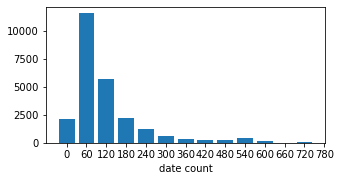

In [20]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.hist(dates['duration'], rwidth=0.8, bins=range(0, 800, 60), align='left')
ax.set_xticks(range(0, 800, 60))
ax.set_xlabel('date duration [min]')
ax.set_xlabel('date count')

dates = dates.sort_values(by='date').reset_index(drop=True)
dates.head(3)

In [21]:
# remove lectures that happened outside TU Graz premises
N = len(lectures)
lectures = lectures[lectures['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lectures), N))

dropped 124/1747 lectures that happened outside TU Graz premises or outside the semester


In [22]:
# remove lecturers that teach lectures outside TU Graz premises
N = len(lecturers['lecturer_id'].unique())
lecturers = lecturers[lecturers['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lecturers that taught lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lecturers['lecturer_id'].unique()), N))

dropped 27/1502 lecturers that taught lectures that happened outside TU Graz premises or outside the semester


In [23]:
# remove student enrollments in lectures that happened outside TU Graz premises
N = len(students)
students = students[students['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} student visits to lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(students), N))

dropped 1653/82716 student visits to lectures that happened outside TU Graz premises or outside the semester


### Visualize term and student counts

there are 106 unique TU Graz or NaWi studies
11861 unique TU Graz or NaWi students are registered at TU Graz

number of studies per student
1    10387
2     1360
3      122
4        7
5        3
7        2
6        1
Name: n_studies, dtype: int64

number of students per study
36    904
30    802
32    755
31    748
37    687
29    681
28    643
34    619
42    566
26    529
Name: n_students, dtype: int64
the mean and median term number was 4.98 and 4.0, respectively
the mean and median number of students per study was 126.50 and 49.0, respectively


,student_id,study_id,study_name,term_number,study_level,study_label
10,163041,UF 066 465,Masterstudium; Bauing.wiss.-Konstruktiver Inge...,1.0,master,t
11,207552,UF 033 245,Bachelorstudium; Maschinenbau,1.0,bachelor,t
15,149959,UF 033 282,Bachelorstudium; Wirtschaftsingenieurwesen-Mas...,11.0,bachelor,t


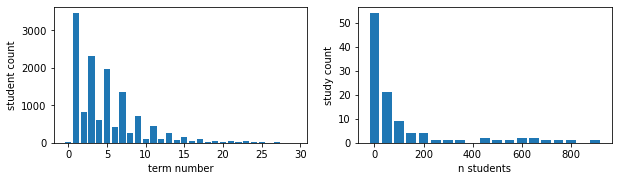

In [24]:
print('there are {} unique TU Graz or NaWi studies'\
      .format(len(students['study_id'].unique())))
print('{} unique TU Graz or NaWi students are registered at TU Graz'\
      .format(len(students['student_id'].unique())))

n_studies = studies[['student_id', 'study_id']]\
    .groupby('student_id')\
    .count()\
    .rename(columns={'study_id':'n_studies'})\
    .reset_index()
print('\nnumber of studies per student')
print(n_studies['n_studies'].value_counts())

n_students = studies[['student_id', 'study_id']]\
    .groupby('study_id')\
    .count()\
    .rename(columns={'student_id':'n_students'})\
    .reset_index()\
    .sort_values(by='n_students', ascending=False)
print('\nnumber of students per study')
print(n_students['n_students'][0:10])

fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
axes[0].hist(studies['term_number'], rwidth=0.8, bins=range(0, 31, 1), align='left')
axes[0].set_xlabel('term number')
axes[0].set_ylabel('student count')

axes[1].hist(n_students['n_students'], rwidth=0.8, bins=range(0, 1000, 50),
             align='left')
axes[1].set_xlabel('n students')
axes[1].set_ylabel('study count')

print('the mean and median term number was {:1.2f} and {}, respectively'\
      .format(studies['term_number'].mean(), studies['term_number'].median()))

print('the mean and median number of students per study was {:1.2f} and {}, respectively'\
      .format(n_students['n_students'].mean(), n_students['n_students'].median()))


studies.head(3)

## Groups

### Map lecture group IDs to lecture IDs

A lecture group is usually the tutorial that takes place alongside the lecture (especially for the lecture type "VU", lecture + tutorial).

In [25]:
# mapping of lecture group IDs to lecture IDs
groups = students[['lecture_id', 'group_id']].drop_duplicates().copy()
assert len(groups) == len(groups['group_id'].unique())

groups2 = lecturers[['lecture_id', 'group_id']].drop_duplicates().copy()
diff = list(set(groups['group_id']).difference(set(groups2['group_id'])))
print('there are {} groups that have no assigned lecturer'.format(len(diff)))

N = len(groups)
groups = groups[groups['group_id'].isin(dates['group_id'].unique())]
print('dropped {}/{} groups that had no assigned date in the range {} - {}'\
      .format(N - len(groups), N, semester_start, semester_end))

print('there are {} unique groups and {} lectures left'\
      .format(len(groups['group_id'].unique()), 
              len(groups['lecture_id'].unique())))

groups = groups.reset_index(drop=True)

groups.head(3)

there are 27 groups that have no assigned lecturer
dropped 381/2459 groups that had no assigned date in the range 2019-10-01 - 2020-02-28
there are 2078 unique groups and 1526 lectures left


,lecture_id,group_id
0,226073,254793
1,226598,260636
2,221416,258125


### Disambiguate group IDs

In [26]:
letter_list = list(string.ascii_lowercase)
dates['new_group_id'] = np.nan
for date in dates['date'].unique():
    #print(date)
    for group_id in groups['group_id']:
        # dates that happen at the same time for the same group
        group_dates = dates[(dates['group_id'] == group_id) & \
                            (dates['date'] == date)]
        # is there more than one date for the same group id on a given day?
        # do the duplicate dates start at the same time?
        if (len(group_dates) > 1) and \
           (len(group_dates['start_time'].drop_duplicates()) < len(group_dates)):
            
            # de-duplicate group ids stat start at the same time by adding a 
            # letter at the end of the id
            for dt in group_dates['datetime']:
                group_datetimes = group_dates[group_dates['datetime'] == dt]
                assert len(group_datetimes) <= len(letter_list)
                #print('\t{}: entries {}'.format(group_id, len(group_datetimes)))
                
                for index, letter in zip(group_datetimes.index, letter_list):
                    dates.loc[index, 'new_group_id'] = '{}{}'.format(group_id, letter)

In [27]:
splits = dates[['group_id', 'new_group_id']].dropna().drop_duplicates()
print('{} groups had more than one date on the same day and at the same time and were split into {} new groups'\
      .format(len(splits['group_id'].unique()), len(splits)))

116 groups had more than one date on the same day and at the same time and were split into 277 new groups


### Assign new group IDs to students

In [28]:
students['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    students_in_group = students[students['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(students_in_group) / len(new_group_ids))
    assert new_group_size >= 1
    
    for i, ID in enumerate(new_group_ids[0:-1]):
        students.loc[students_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index]['new_group_id']\
            = ID
    students.loc[students_in_group[(i + 1) * new_group_size:].index]['new_group_id']\
            = new_group_ids[-1]

### Assign new group IDs to lecturers

In [29]:
lonely_groups = 0
lecturers['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    lecturers_in_group = lecturers[lecturers['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(lecturers_in_group) / len(new_group_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_group_size == 1:
        lonely_groups += 1
        
    for i, ID in enumerate(new_group_ids[0:-1]):
        lecturers.loc[lecturers_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index, 'new_group_id']\
            = ID
    lecturers.loc[lecturers_in_group[(i + 1) * new_group_size:].index, 'new_group_id']\
            = new_group_ids[-1]
    
print('{} split groups have no lecturer now'.format(lonely_groups))

38 split groups have no lecturer now


### Add lecture type information to groups

In [33]:
groups = groups.set_index("lecture_id")
lectures = lectures.set_index("lecture_id")
groups = groups.join(lectures["lecture_type"]).reset_index()
lectures = lectures.reset_index()

## Exams

In [35]:
def fix_dates(datestring):
    datestring = datestring.replace('Okt','10')
    datestring = datestring.replace('Nov','11')
    datestring = datestring.replace('Dez','12')
    datestring = datestring.replace('Jän','01')
    datestring = datestring.replace('Feb','02')
    return pd.to_datetime(datestring, dayfirst=True)

In [36]:
estudents = pd.read_csv(join(src, 'Prüfungen-2.csv'), encoding='latin_1')
estudents = estudents.rename(columns={
    'PV_TERM_NR':'exam_id',
    'ST_PERSON_NR':'student_id',
    'STP_SP_NR':'lecture_id',
    'PRUEFUNGSDATUM':'date',
    'STUDIENIDENTIFIKATOR':'study_id'})
estudents['study_label'] = estudents['study_id'].replace(label_map)
estudents['date'] = estudents['date'].apply(fix_dates)
estudents.head(3)

,exam_id,date,student_id,study_id,lecture_id,study_label
0,1278904,2019-12-13,183153,UB 033 662,213079,n
1,1278904,2019-12-13,183491,UF 033 662,213079,n
2,1278904,2019-12-13,194797,UB 033 662,213079,n


## Exam dates

In [37]:
def get_time(timestring):
    if timestring != timestring:
        return np.nan
    else:
        hour, minute = timestring.split(':')
        return datetime.time(int(hour), int(minute))

In [38]:
edates = pd.read_csv(join(src, 'Prüfungstermine_mit_Räumen.csv'), encoding='latin_1',
                     parse_dates=['DATUM'], dayfirst=True)
edates = edates.rename(columns={
    'PV_TERM_NR':'exam_id',
    'PERSON_NR':'lecturer_id',
    'STP_SP_NR':'lecture_id',
    'DATUM':'date',
    'RES_NR':'room_id',
    'BEGINNZEIT':'start_time',
    'ENDEZEIT':'end_time'})

print('{}/{} exam dates have no room information'\
      .format(len(edates) - len(edates.dropna(subset=['room_id'])),
              len(edates)))

3661/5633 exam dates have no room information


### Disambiguate exam IDs

In [39]:
# disambiguate exam IDs
letter_list = list(string.ascii_lowercase)
edates['new_exam_id'] = np.nan
for exam_id in edates['exam_id'].unique():
    exam_info = edates[edates['exam_id'] == exam_id]
    if len(exam_info) > 1:
        assert len(exam_info) <= len(letter_list)
        for index, letter in zip(exam_info.index, letter_list):
            edates.loc[index, 'new_exam_id'] = '{}{}'.format(exam_id, letter)
            
esplits = edates[['exam_id', 'new_exam_id']].dropna().drop_duplicates()
print('{} exams had more than one date on the same day and at the same time and were split into {} new exam groups'\
      .format(len(esplits['exam_id'].unique()), len(esplits)))

45 exams had more than one date on the same day and at the same time and were split into 121 new exam groups


### Assign new exam IDs to students

In [40]:
estudents['new_exam_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    students_in_exam = estudents[estudents['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(students_in_exam) / len(new_exam_ids))
    
    # only a single student in the exam
    if new_exam_size == 1:
        estudents.loc[students_in_exam.index[0], 'new_exam_id'] = new_exam_ids[0]
        
    # more than one student in the exam: split them between the different rooms
    else:
        for i, ID in enumerate(new_exam_ids[0:-1]):
            estudents.loc[students_in_exam[\
                i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
                = ID
        estudents.loc[students_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
                = new_exam_ids[-1]

### Assign new exam IDs to lecturers

In [41]:
electurers = edates[['exam_id', 'lecturer_id']].copy()
lonely_exams = 0
electurers['new_group_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    lecturers_in_exam = electurers[electurers['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(lecturers_in_exam) / len(new_exam_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_exam_size == 1:
        lonely_exams += 1
        
    for i, ID in enumerate(new_exam_ids[0:-1]):
        electurers.loc[lecturers_in_exam[\
            i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
            = ID
    electurers.loc[lecturers_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
            = new_exam_ids[-1]
    
print('{} split exams have no lecturer now'.format(lonely_exams))

45 split exams have no lecturer now


### Calculate exam durations & set duration defaults

In [42]:
edates['start_time'] = edates['start_time'].apply(get_time)
edates['end_time'] = edates['end_time'].apply(get_time)
edates['duration'] = edates.apply(ncf.calculate_duration, axis=1)

N = len(edates)
print("{}/{} exams don't specify a duration"\
      .format(N - len(edates.dropna(subset=['duration'])), N))
duration_default = edates['duration'].median()
print("the default duration (median) is {} minutes".format(duration_default))
edates['duration'] = edates['duration'].fillna(duration_default)

print('there are {} exams with a duration of > 600 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] > 360]), duration_default))
print('there are {} exams with a duration of < 30 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] < 30]), duration_default))
edates.loc[edates[edates['duration'] > 360].index, 'duration'] = duration_default
edates.loc[edates[edates['duration'] < 30].index, 'duration'] = duration_default
edates.head(3)

2889/5633 exams don't specify a duration
the default duration (median) is 120.0 minutes
there are 49 exams with a duration of > 600 min -> replaced with 120.0 min
there are 24 exams with a duration of < 30 min -> replaced with 120.0 min


,exam_id,lecturer_id,date,start_time,end_time,room_id,lecture_id,new_exam_id,duration
0,1280079,1773,2019-12-02,10:15:00,12:00:00,2661.0,227402,NaN,105.0
1,1269842,44990,2020-02-28,14:00:00,NaN,2541.0,226034,NaN,120.0
2,1276611,107131,2019-10-16,16:30:00,17:30:00,261.0,212311,NaN,60.0


In [43]:
exams = edates[['exam_id', 'lecture_id']].drop_duplicates()

In [50]:
exams = exams.set_index("lecture_id")
lectures = lectures.set_index("lecture_id")
exams = exams.join(lectures["lecture_type"]).reset_index()
lectures = lectures.reset_index()

### Visualize exam durations

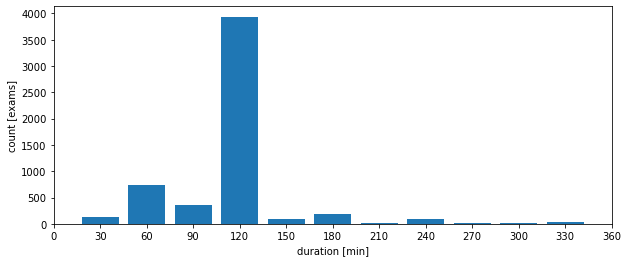

In [56]:
duration_counts = edates['duration']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'duration':'count', 'index':'duration'})\
    .sort_values(by='duration', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(edates['duration'], bins=range(30, 361, 30), rwidth=0.8, align='left')
ax.set_xticks(range(0, 361, 30))
ax.set_ylabel('count [exams]')
ax.set_xlabel('duration [min]');

### Visualize timeline of exam-active students

In [57]:
exam_counts = edates[['date', 'exam_id']]\
    .drop_duplicates()\
    .groupby('date')\
    .count()\
    .reset_index()\
    .rename(columns={'exam_id':'exam_count'})\
    .sort_values(by='date')

In [58]:
exam_active_students_counts = estudents[['date', 'student_id']]\
    .drop_duplicates()\
    .groupby('date')\
    .count()\
    .reset_index()\
    .rename(columns={'student_id':'student_count'})\
    .sort_values(by='date')

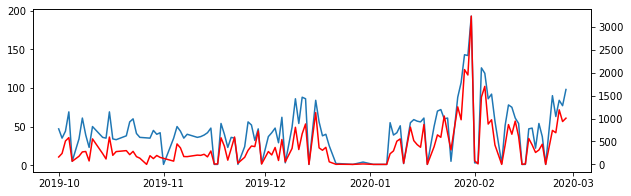

In [59]:
fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()
ax.plot(exam_counts['date'], exam_counts['exam_count'])
ax2.plot(exam_active_students_counts['date'], 
        exam_active_students_counts['student_count'], color='r')

## Save the processed data

In [60]:
processed_dst = '../data/processed'
students.to_csv(join(processed_dst, 'students_processed.csv'), index=False)
lecturers.to_csv(join(processed_dst, 'lecturers_processed.csv'), index=False)
lectures.to_csv(join(processed_dst, 'lectures_processed.csv'), index=False)
studies.to_csv(join(processed_dst, 'studies_processed.csv'), index=False)
organisations.to_csv(join(processed_dst, 'organisations_processed.csv'), index=False)
groups.to_csv(join(processed_dst, 'groups_processed.csv'), index=False)
dates.to_csv(join(processed_dst, 'dates_processed.csv'), index=False)
rooms.to_csv(join(processed_dst, 'rooms_processed.csv'), index=False)
estudents.to_csv(join(processed_dst, 'exam_students_processed.csv'), index=False)
electurers.to_csv(join(processed_dst, 'exam_lecturers_processed'), index=False)
exams.to_csv(join(processed_dst, 'exams.csv'), index=False)
edates.to_csv(join(processed_dst, 'exam_dates.csv'), index=False)